In [ ]:
!pip install requests pandas matplotlib seaborn nltk wordcloud


In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Optional: For sentiment analysis & word cloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

# Download NLTK resources if needed
nltk.download('vader_lexicon')

# Set up plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# API Key & URL
api_key = "API_KEY"
base_url = "https://newsapi.org/v2/everything"

# Define query parameters: Fetch articles about "technology" from past 3 days
today = datetime.utcnow()
yesterday = today - timedelta(days=3)

params = {
    "q": "infosys",
    "from": yesterday.strftime('%Y-%m-%dT%H:%M:%SZ'),
    "to": today.strftime('%Y-%m-%dT%H:%M:%SZ'),
    "language": "en",
    "sortBy": "publishedAt",
    "pageSize": 100,
    "apiKey": api_key
}

# Fetch data
response = requests.get(base_url, params=params)
data = response.json()

# Check API response status
if data.get("status") != "ok":
    raise Exception("Error fetching data:", data.get("message"))

# Convert to DataFrame
articles = data.get("articles", [])
df = pd.DataFrame(articles)
print("Fetched", len(df), "articles.")


Fetched 88 articles.


In [ ]:
# Convert publishedAt to datetime format
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

# Extract relevant columns
df = df[['source', 'title', 'description', 'publishedAt']]
df['source'] = df['source'].apply(lambda x: x.get('name'))

# Sort DataFrame by published date
df.sort_values('publishedAt', inplace=True)

# Show first few records
df.head()


<ipython-input-23-db336e7ffdfc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['source'] = df['source'].apply(lambda x: x.get('name'))
<ipython-input-23-db336e7ffdfc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('publishedAt', inplace=True)


,source,title,description,publishedAt
87,The Times of India,"Ditch the Accenture Prism. TCS, Infy good bets...",Accenture’s read-through for Indian IT appears...,2025-03-24 06:54:11+00:00
86,Securityaffairs.com,Cloak ransomware group hacked the Virginia Att...,The Cloak ransomware group claims responsibili...,2025-03-24 07:22:44+00:00
85,BusinessLine,"Sensex surges over 1,000 points, Nifty nears 2...","Sensex and Nifty rise, led by banking and powe...",2025-03-24 07:31:04+00:00
84,The Times of India,India stocks reverse 2025 losses on back of li...,Indian stocks have recovered from this year’s ...,2025-03-24 07:31:22+00:00
83,BusinessLine,"Top gainers & losers intraday March 24, 2025: ...",Banking and energy sectors outperformed all in...,2025-03-24 07:40:50+00:00


<ipython-input-24-550e5fe37a0c>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['publishedAt'].dt.floor('H')


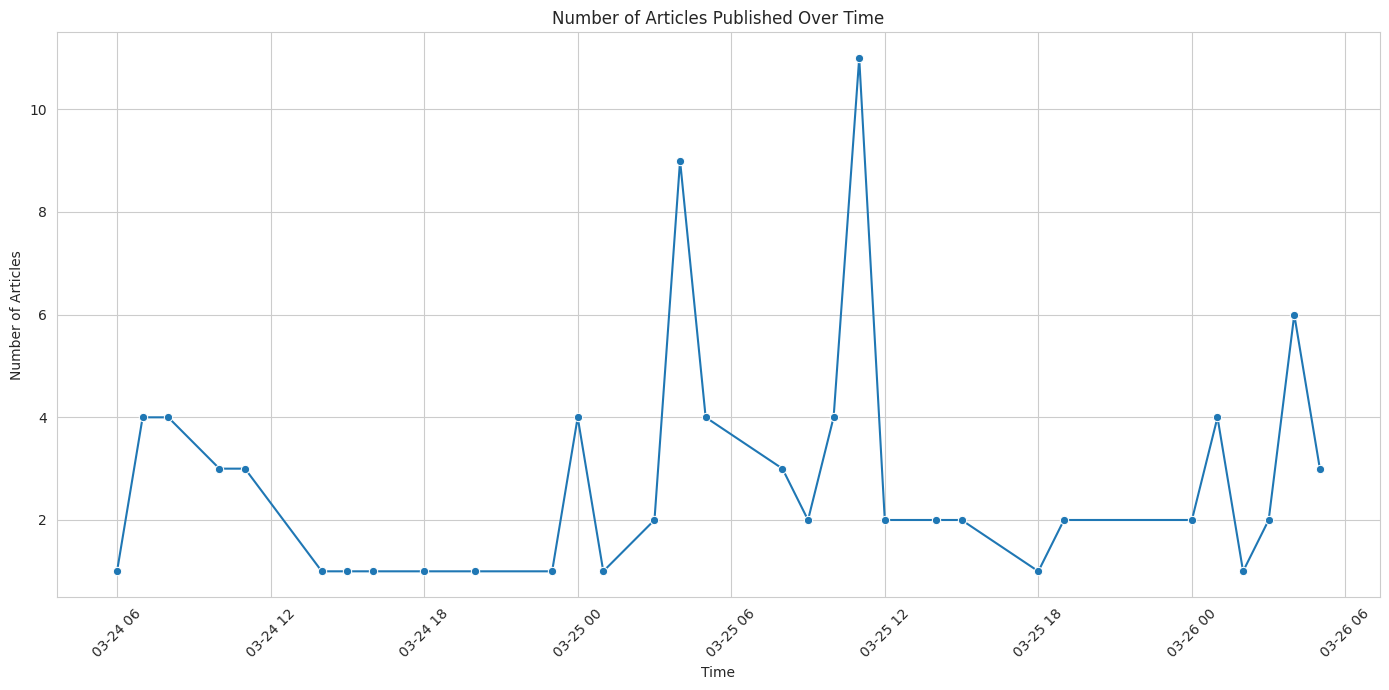

In [ ]:
# Block 4: Articles Over Time
# Group by hour and count articles
df['hour'] = df['publishedAt'].dt.floor('H')
articles_per_hour = df.groupby('hour').size().reset_index(name='count')

plt.figure()
sns.lineplot(x='hour', y='count', data=articles_per_hour, marker='o')
plt.title("Number of Articles Published Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-25-b535b442b55a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='source', data=source_counts, palette="viridis")


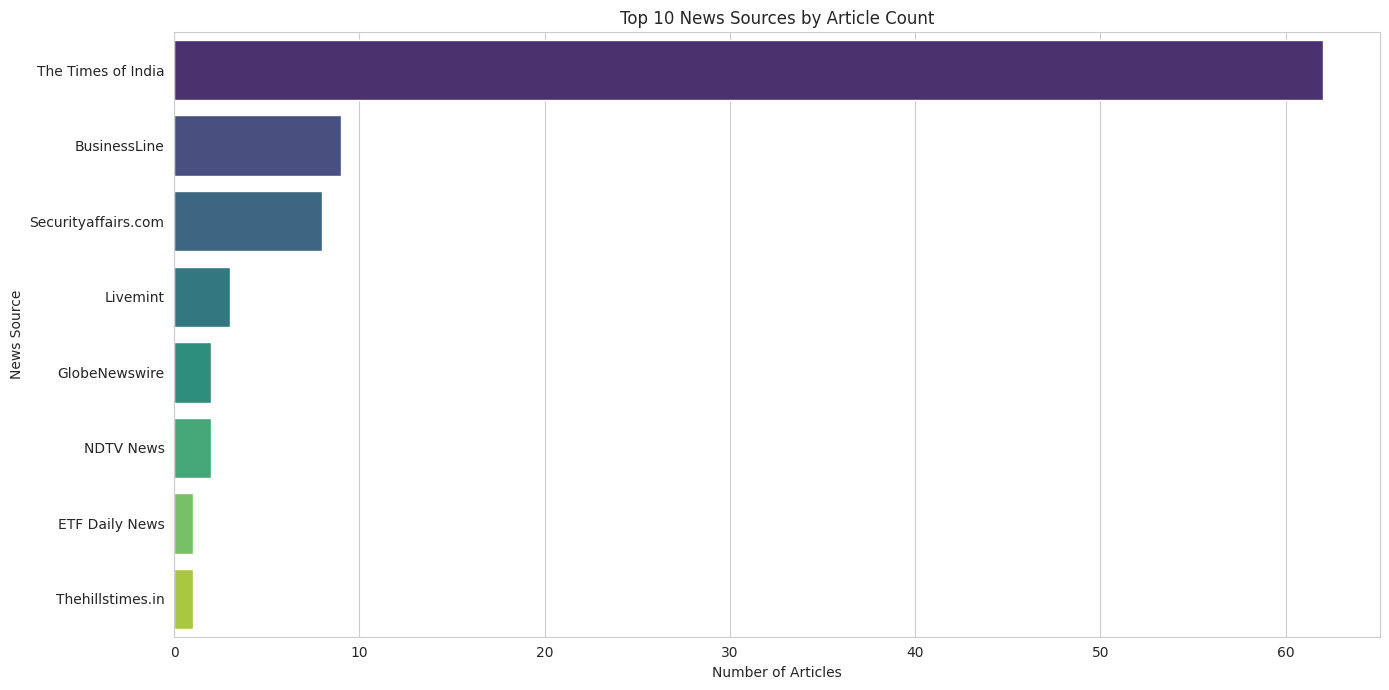

In [ ]:
#  Top News Sources
source_counts = df['source'].value_counts().head(10).reset_index()
source_counts.columns = ['source', 'count']

plt.figure()
sns.barplot(x='count', y='source', data=source_counts, palette="viridis")
plt.title("Top 10 News Sources by Article Count")
plt.xlabel("Number of Articles")
plt.ylabel("News Source")
plt.tight_layout()
plt.show()


In [ ]:
# Initialize Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Compute sentiment scores for each title
df['sentiment_score'] = df['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'] if isinstance(x, str) else 0)

# Classify articles into Positive, Neutral, Negative
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))

# Display first few records with sentiment
df[['title', 'sentiment_score', 'sentiment']].tail()


,title,sentiment_score,sentiment
4,Share market update: Most active stocks on D-S...,0.6361,Positive
3,Share market update: Most active stocks of the...,0.7645,Positive
2,Stock market update: Mining stocks up as marke...,0.0000,Neutral
1,Stock market update: Stocks that hit 52-week h...,0.0000,Neutral
0,Stock market update: Nifty IT index falls 0.08...,-0.0516,Negative


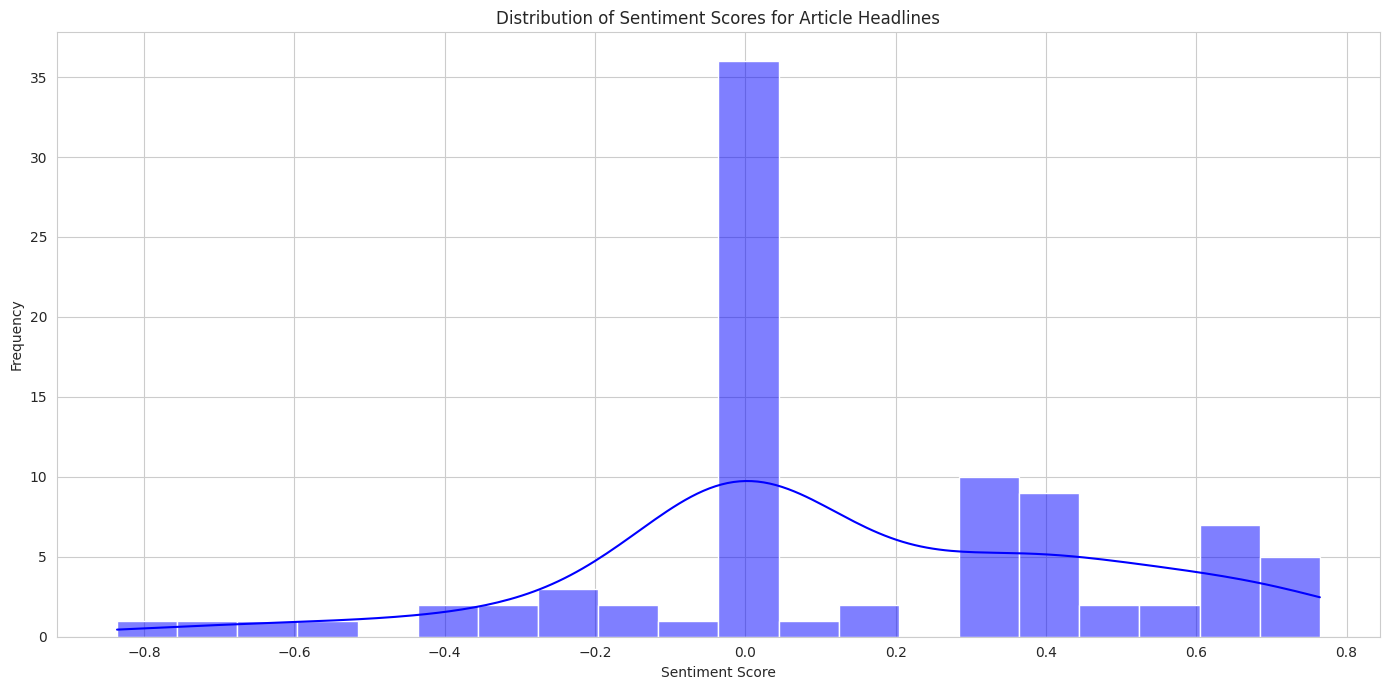

In [ ]:
plt.figure()
sns.histplot(df['sentiment_score'], bins=20, kde=True, color="blue")
plt.title("Distribution of Sentiment Scores for Article Headlines")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


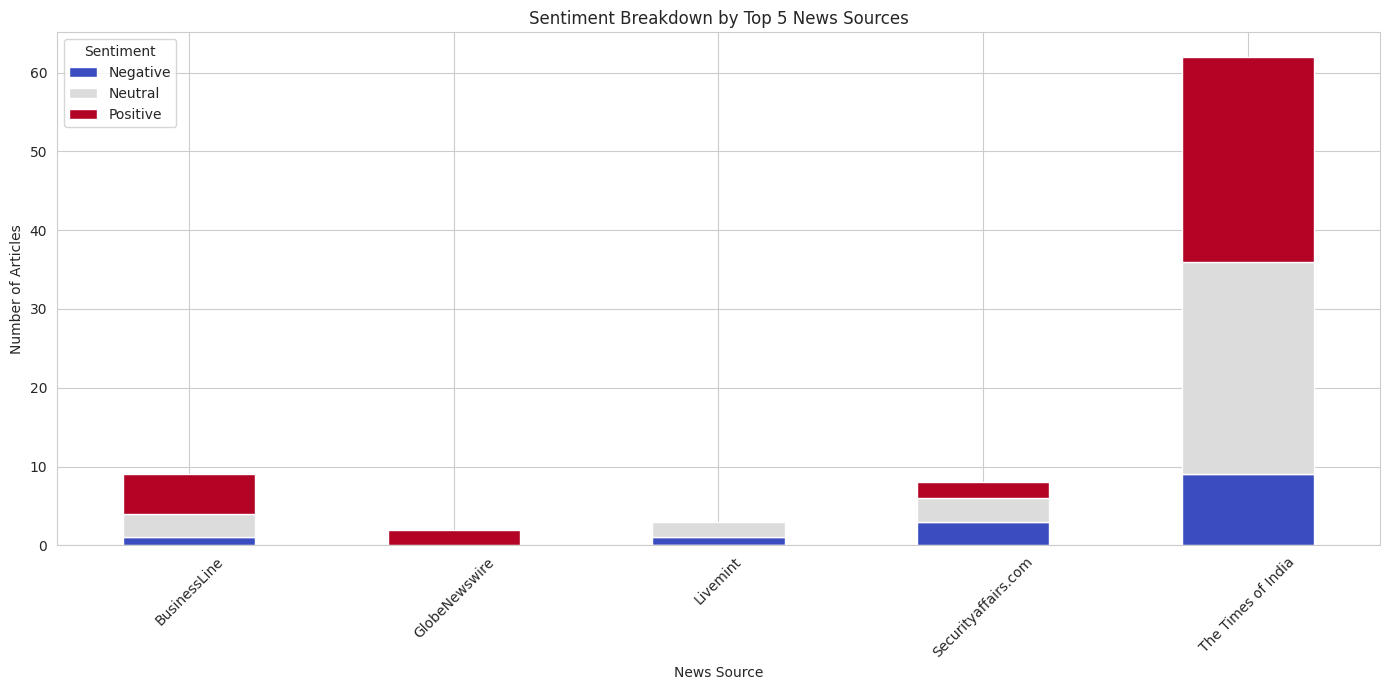

In [ ]:
# Count sentiment categories for top 5 sources
top_sources = df['source'].value_counts().head(5).index
sentiment_counts = df[df['source'].isin(top_sources)].groupby(['source', 'sentiment']).size().unstack()

# Plot stacked bar chart
sentiment_counts.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title("Sentiment Breakdown by Top 5 News Sources")
plt.xlabel("News Source")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


In [ ]:
# Top 5 positive articles
print("\n🔹 Top 5 Positive Articles:\n")
print(df.nlargest(5, 'sentiment_score')[['title', 'source', 'sentiment_score']])

# Top 5 negative articles
print("\n🔹 Top 5 Negative Articles:\n")
print(df.nsmallest(5, 'sentiment_score')[['title', 'source', 'sentiment_score']])



🔹 Top 5 Positive Articles:

                                                title              source  \
77  Share market update: Most active stocks of the...  The Times of India   
55  Share market update: Most active stocks of the...  The Times of India   
39  Share market update: Most active stocks of the...  The Times of India   
3   Share market update: Most active stocks of the...  The Times of India   
62  Share Market Highlights: Sensex, Nifty hold st...        BusinessLine   

    sentiment_score  
77           0.7645  
55           0.7645  
39           0.7645  
3            0.7645  
62           0.6908  

🔹 Top 5 Negative Articles:

                                                title               source  \
74  Attackers can bypass middleware auth checks by...  Securityaffairs.com   
24  Leaked hiring memo sparks outrage over elite-o...   The Times of India   
43  US recruiter's leaked email exposes hiring cri...             Livemint   
31  Top gainers & losers today, 25 

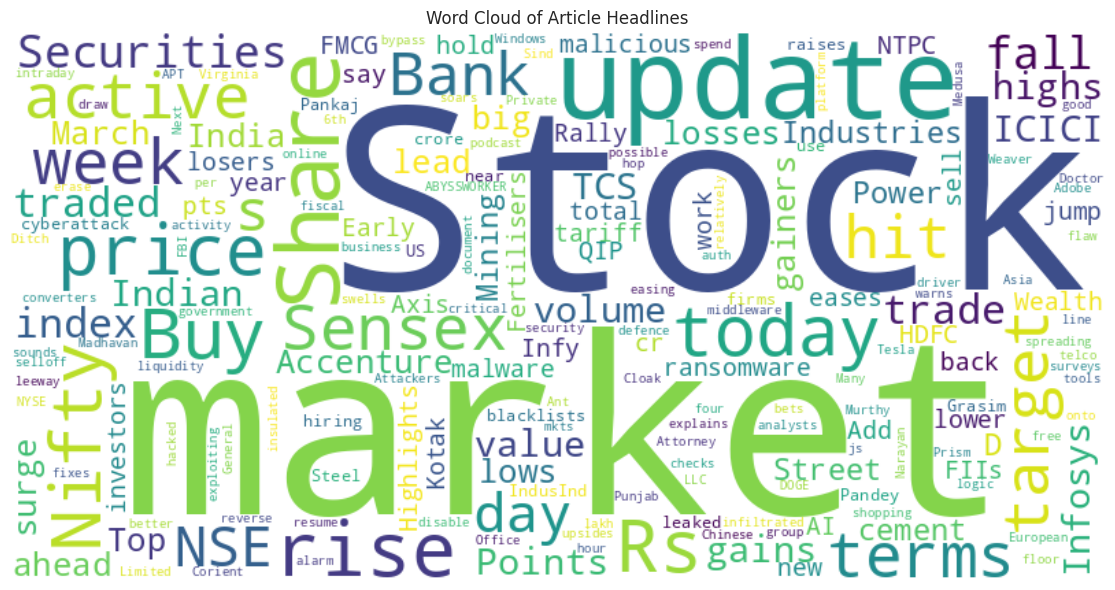

In [ ]:
# Combine all headlines into one text
all_titles = " ".join(df['title'].dropna().tolist())

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(all_titles)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Article Headlines")
plt.tight_layout()
plt.show()
